In [1294]:
%run cv.ipynb

In [2]:
train = pd.read_csv(input_path + '/train_data.csv', sep=',')
test = pd.read_csv(input_path + '/test_data.csv', sep=',')
train_answers = pd.read_csv(input_path + '/train_answers.csv', sep=',')

In [3]:
len(train.userId.unique()), len(test.userId.unique()), len(np.intersect1d(train.userId.unique(), test.userId.unique()))

(1357, 1192, 1001)

In [4]:
tr = train.join(train_answers.set_index('itemId'), how='left', on='itemId')
tr['isMinmax'] = (tr.Xmin_true <= tr.Xmin) & (tr.Xmax <= tr.Xmax_true) & (tr.Ymin_true <= tr.Ymin) & (tr.Ymax <= tr.Ymax_true)
tr.groupby('itemId').agg({'isMinmax': 'all'}).mean()

isMinmax    0.103924
dtype: float64

In [5]:
tr = train.join(train_answers.set_index('itemId'), how='left', on='itemId')
tr['isMinmax'] = (tr.Xmax_true >= tr.Xmax)
tr.groupby('itemId').agg({'isMinmax': 'all'}).mean()

isMinmax    0.481442
dtype: float64

In [14]:
(train.Ymin <= train.Ymax).mean()

1.0

In [739]:
class MinMaxModel2(MyModel):
    def fit(self, train, train_answers):
        pass
    def get_base_result(self, X):
        sssdd()
        result = []
        for items in split_by(X, 'itemId'):
            x1 = items.Xmin.min()
            x2 = items.Xmax.max()
            y1 = items.Ymin.min()
            y2 = items.Ymax.max()
            itemId = items.itemId.values[0]
            result.append([itemId, x1, y1, x2, y2])
        return result      
    def get_base_result_cached(self, X):
        if self.params.get('use_cache', False):
            self.params['_predict_cache'] = self.params.get('_predict_cache', {})
            h = get_df_hash(X)
            if h in self.params['_predict_cache']:
                minmax_result = self.params['_predict_cache'][h]
            else:
                minmax_result = self.get_base_result(X)
                self.params['_predict_cache'][h] = minmax_result
        else:
            minmax_result = self.get_base_result(X)
            
        return copy.deepcopy(minmax_result)
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        for row in minmax_result:
            if row[1] >= 70:
                row[1] -= row[1] * self.params.get('mult')
            
        return pd.DataFrame(minmax_result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 
#model = MinMaxModel2()
#model.fit(train, train_answers)
#print(get_score(train_answers, model.predict(train)))

In [671]:
cross_validation(MinMaxModel2({'mult':14/60.0}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.5868, mean=0.5868
 0 - 2 : 0.5895, mean=0.5881
 0 - 3 : 0.5714, mean=0.5826
 0 - 4 : 0.5804, mean=0.5820
 0 - 5 : 0.5925, mean=0.5841
KFold(n_splits=5, random_state=2708, shuffle=True)
 1 - 1 : 0.5774, mean=0.5830
 1 - 2 : 0.5873, mean=0.5836
 1 - 3 : 0.5764, mean=0.5827
 1 - 4 : 0.5942, mean=0.5840
 1 - 5 : 0.5851, mean=0.5841
KFold(n_splits=5, random_state=2709, shuffle=True)
 2 - 1 : 0.5869, mean=0.5844
 2 - 2 : 0.5831, mean=0.5843
 2 - 3 : 0.5863, mean=0.5844
 2 - 4 : 0.5819, mean=0.5842
 2 - 5 : 0.5823, mean=0.5841
KFold(n_splits=5, random_state=2710, shuffle=True)
 3 - 1 : 0.5806, mean=0.5839
 3 - 2 : 0.5755, mean=0.5834
 3 - 3 : 0.5805, mean=0.5832
 3 - 4 : 0.6060, mean=0.5844
 3 - 5 : 0.5779, mean=0.5841
KFold(n_splits=5, random_state=2711, shuffle=True)
 4 - 1 : 0.5862, mean=0.5842
 4 - 2 : 0.5833, mean=0.5842
 4 - 3 : 0.5966, mean=0.5847
 4 - 4 : 0.5657, mean=0.5839
 4 - 5 : 0.5886, mean=0.5841


0.5841022446006188

In [988]:
class GeneticSearchModel(MyModel):
    def __init__(self, params={}):
        self.model_class = MinMaxModelEx2
        self.params = params
        self.sub_params = {
            'use_cache': True,
        }
    def fit(self, train, train_answers):
        self.train = train
        self.train_answers = train_answers
        self.population = Population(size=self.params['size'], items=[
            MutableFloatFactory(min_value=0.2, max_value=1.5),
            MutableFloatFactory(min_value=0.2, max_value=1.5),
        ], score_getter=lambda x: self.score_getter(x))
        for i in range(self.params['epochs']):
            self.population.do_epoch()
        
    def set_sub_params(self, params):
        self.sub_params['mult_dx'],\
        self.sub_params['mult_dd'] = params
        
#        self.sub_params['mult_x1_sqrt'],\
#        self.sub_params['mult_x1'],\
        
    def score_getter(self, params):
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return get_score(self.train_answers, model.predict(self.train)) 
    
    def predict(self, X):
        params = self.population.get_best_values()
        self.set_sub_params(params)
        model = self.model_class(self.sub_params)
        model.fit(self.train, self.train_answers)
        return model.predict(X)

In [701]:
seed_everything(34322)
cross_validation(GeneticSearchModel({'epochs': 25, 'size': 17}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
Top scores at 0 epoch: 0.5750271637544085, 0.5714917043609269, 0.5744290260243545, 0.5835552852343027, 0.5812625550077336, 0.5829941450598801, 0.5831364555627813, 0.5762774121096103, 0.5817518947597137, 0.5811657050167998, 0.5781941650322131
Best values: 0.8445277911623574
Top scores at 1 epoch: 0.5836221493529163, 0.5835552852343027, 0.5835184512558289, 0.5834292480680533, 0.5831485427868438, 0.5831364555627813, 0.5831195903763926, 0.5830504608705608, 0.5829941450598801, 0.5817518947597137, 0.5813760862041585
Best values: 0.27215309410561916
Top scores at 2 epoch: 0.5837514437450527, 0.5836565269170599, 0.5836221493529163, 0.5835552852343027, 0.5835184512558289, 0.583499103199546, 0.5834292480680533, 0.5832316418233853, 0.5831485427868438, 0.5831364555627813, 0.5831195903763926
Best values: 0.3236678580653737
Top scores at 3 epoch: 0.5837514437450527, 0.5837065703869694, 0.5836565269170599, 0.5836221493529163, 0.5836124545569064, 0.58

Top scores at 3 epoch: 0.5852429984163012, 0.585240612705032, 0.585233926738273, 0.5852298966914563, 0.585225259927688, 0.58522211626034, 0.5852105362626742, 0.5852102182445715, 0.5851871631121844, 0.585175401457021, 0.5851731985909889
Best values: 0.3063531778699181
Top scores at 4 epoch: 0.5852447177820385, 0.5852429984163012, 0.585240612705032, 0.585233926738273, 0.5852298966914563, 0.585225259927688, 0.58522211626034, 0.5852105362626742, 0.5852102182445715, 0.5851871631121844, 0.585175401457021
Best values: 0.30749063363968887
Top scores at 5 epoch: 0.5852555791120769, 0.5852498777503611, 0.5852447177820385, 0.5852429984163012, 0.585240612705032, 0.585233926738273, 0.5852298966914563, 0.585225259927688, 0.58522211626034, 0.5852105362626742, 0.5852102182445715
Best values: 0.31532323362518894
Top scores at 6 epoch: 0.5852555791120769, 0.5852498777503611, 0.5852447177820385, 0.5852429984163012, 0.585240612705032, 0.5852402225476705, 0.585233926738273, 0.5852298966914563, 0.5852252599

Top scores at 6 epoch: 0.5836058761706537, 0.5836021939042783, 0.5835981859060959, 0.5835974288859174, 0.5835799188166598, 0.5835796314243967, 0.5835773823518458, 0.5835686267999681, 0.5835601048022832, 0.5835513383524609, 0.5835269635573905
Best values: 0.32399515639573856
Top scores at 7 epoch: 0.5836058761706537, 0.5836021939042783, 0.5836003662864608, 0.5835998296461679, 0.5835981859060959, 0.5835974288859174, 0.5835799188166598, 0.5835796314243967, 0.5835773823518458, 0.5835686267999681, 0.5835601048022832
Best values: 0.32399515639573856
Top scores at 8 epoch: 0.5836058761706537, 0.5836021939042783, 0.5836003662864608, 0.5835998296461679, 0.5835981859060959, 0.5835974288859174, 0.5835959327580722, 0.5835799188166598, 0.5835796314243967, 0.5835773823518458, 0.5835686267999681
Best values: 0.32399515639573856
 1 - 2 : 0.5872, mean=0.5837
Top scores at 0 epoch: 0.5848947182637787, 0.5717086314113381, 0.5860218651036184, 0.5852909204911945, 0.5835144431175366, 0.5757788357892094, 0.5

Top scores at 0 epoch: 0.5748740291328102, 0.5832556305586, 0.580172556453988, 0.5826288798133136, 0.57906487635694, 0.580324546778215, 0.5830477603932054, 0.5818070640198011, 0.5714839278221633, 0.5815365767436402, 0.5827007037198904
Best values: 0.8344201450645439
Top scores at 1 epoch: 0.583517439613873, 0.5835086170561521, 0.5834849558814893, 0.5834247950373471, 0.5832556305586, 0.58321575945954, 0.5830620581524272, 0.5830477603932054, 0.5829025366533664, 0.5828903703100144, 0.5827462838763308
Best values: 0.2938693046516899
Top scores at 2 epoch: 0.583517439613873, 0.5835113933064544, 0.5835086170561521, 0.5835029664632517, 0.5834849558814893, 0.5834822707710025, 0.5834490636007731, 0.5834247950373471, 0.583411730648876, 0.5833745051413761, 0.5832556305586
Best values: 0.2938693046516899
Top scores at 3 epoch: 0.583517439613873, 0.5835169409152619, 0.5835166362445964, 0.5835113933064544, 0.5835086170561521, 0.583505967205825, 0.5835029664632517, 0.5834849558814893, 0.5834822707710

Top scores at 3 epoch: 0.5849529979577306, 0.5849289761335672, 0.5849285957146525, 0.5849054408339506, 0.5849038788902471, 0.5848904774965615, 0.5848795760474631, 0.58486216083761, 0.5848249049446309, 0.5848246064482193, 0.5848030598003293
Best values: 0.31836708087056387
Top scores at 4 epoch: 0.5849529979577306, 0.5849289761335672, 0.5849285957146525, 0.5849054408339506, 0.5849038788902471, 0.5848904774965615, 0.5848795760474631, 0.58486216083761, 0.5848249049446309, 0.5848246064482193, 0.5848030598003293
Best values: 0.31836708087056387
Top scores at 5 epoch: 0.5849529979577306, 0.5849289761335672, 0.5849285957146525, 0.5849054408339506, 0.5849038788902471, 0.5848904774965615, 0.5848849276437322, 0.5848795760474631, 0.58486216083761, 0.5848249049446309, 0.5848246064482193
Best values: 0.31836708087056387
Top scores at 6 epoch: 0.5849529979577306, 0.5849377940211032, 0.5849289761335672, 0.5849285957146525, 0.5849080303528686, 0.5849054408339506, 0.5849038788902471, 0.5848904774965615

Top scores at 6 epoch: 0.5864489267365979, 0.5864469030435612, 0.5864427453151213, 0.5864402881810461, 0.5864282271974355, 0.5864254618846217, 0.586415257189124, 0.5864144786031007, 0.5864064489217349, 0.5864022616746304, 0.5864010857172908
Best values: 0.30744447206566816
Top scores at 7 epoch: 0.5864549571175843, 0.5864510710142589, 0.5864489267365979, 0.5864469030435612, 0.5864427453151213, 0.5864402881810461, 0.5864282271974355, 0.5864254618846217, 0.586415257189124, 0.5864144786031007, 0.5864064489217349
Best values: 0.31782385665283996
Top scores at 8 epoch: 0.5864561463445825, 0.5864553619855558, 0.5864549571175843, 0.5864510710142589, 0.5864489267365979, 0.5864469030435612, 0.5864427453151213, 0.5864402881810461, 0.5864314535158383, 0.5864282271974355, 0.5864254618846217
Best values: 0.31612547167034766
 3 - 2 : 0.5759, mean=0.5836
Top scores at 0 epoch: 0.584771844073812, 0.5720035146094373, 0.578483088402824, 0.583536368842879, 0.5849435916188399, 0.5824178651127441, 0.584520

 3 - 5 : 0.5778, mean=0.5843
KFold(n_splits=5, random_state=2711, shuffle=True)
Top scores at 0 epoch: 0.5818931741552757, 0.58370350494926, 0.5700288143283426, 0.5837044832884619, 0.5750250350402514, 0.5823529857445152, 0.5786270455404838, 0.583270490454875, 0.583656197096791, 0.5772021228154047, 0.576181564732227
Best values: 0.5385321624072623
Top scores at 1 epoch: 0.5837049936169589, 0.5837044832884619, 0.58370350494926, 0.5836958924282434, 0.583656197096791, 0.583475101122012, 0.5833968693966102, 0.5833470802382219, 0.583270490454875, 0.583263406653061, 0.5823853434414548
Best values: 0.2984440143298444
Top scores at 2 epoch: 0.5837057115866174, 0.5837049936169589, 0.5837044832884619, 0.58370350494926, 0.5836958924282434, 0.5836619439537432, 0.5836585304056807, 0.583656197096791, 0.5836127965087986, 0.5835794120845983, 0.5834769092524719
Best values: 0.3202877988353814
Top scores at 3 epoch: 0.5837102705775051, 0.583709901819691, 0.5837066553031769, 0.5837057115866174, 0.58370499

Top scores at 3 epoch: 0.5887991490568821, 0.5887991325960873, 0.5887990243105019, 0.5887953081473714, 0.5887931071227986, 0.5887883660978763, 0.588781110657195, 0.588762619058052, 0.5887189841869194, 0.5886923595783223, 0.5886118643809923
Best values: 0.3115203718026365
Top scores at 4 epoch: 0.5887991490568821, 0.5887991325960873, 0.5887990243105019, 0.5887953081473714, 0.5887931071227986, 0.5887925768139574, 0.5887883660978763, 0.588781110657195, 0.588777256458172, 0.588762619058052, 0.5887362204172644
Best values: 0.3115203718026365
Top scores at 5 epoch: 0.5887991490568821, 0.5887991325960873, 0.5887990243105019, 0.5887958604486999, 0.5887953081473714, 0.5887931071227986, 0.5887925768139574, 0.5887883660978763, 0.588781110657195, 0.588777256458172, 0.5887672255608762
Best values: 0.3115203718026365
Top scores at 6 epoch: 0.5887991490568821, 0.5887991325960873, 0.5887990243105019, 0.5887974467609152, 0.5887958604486999, 0.5887953081473714, 0.5887943691758133, 0.5887931071227986, 0.

0.584270949972088

In [989]:
# genetic

class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        return self.model.predict(self.get_X(data))
            
class MinMaxModelEx2(MinMaxModel2):
    def fit(self, train, train_answers):
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        
        h = get_df_hash(train)
        if self.params.get('use_cache', False):
            self.params['_fit_cache'] = self.params.get('_fit_cache', {})
            if h not in self.params['_fit_cache']:
                feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
                params = {
                    'boosting_type': 'gbdt',
                    'min_data_in_leaf': 100,
                    'lambda_l2': 0.5,
                    'num_leaves': 5,
                    'learning_rate': 0.007,
                    'feature_fraction': 1,
                    'bagging_fraction': 1,
                    'bagging_freq': 1,
                    'num_boost_round': 700,
                    'verbose': 0,
                }
                model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
                model_x1.fit(feats_x1)
                self.params['_fit_cache'][h] = model_x1
            else:
                model_x1 = self.params['_fit_cache'][h]
        else:
            sdsdsdsd()
            
        self.model_x1 = model_x1
    def get_base_result(self, X):
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)

        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
        })
        assert pred.shape[0] == feats_x1.shape[0]
        
        result = []
        for items in feats_x1.join(pred.set_index('itemId'), on='itemId').itertuples():
            x1 = items.Xmin_min
            y1 = items.Ymin_min
            x2 = items.Xmax_max
            y2 = items.Ymax_max
            x1_init = x1
            if x1 >= 70:
                x1 -= items.target_x1

            result.append([items.itemId, x1, y1, x2, y2, x1_init, items.Xmax_max2 - items.Xmax_max])
        return result
        
    def predict(self, X):
        minmax_result = self.get_base_result_cached(X)
        for row in minmax_result:
            x1_init = row[5]
            x1_delta = row[6]
            
            if x1_init >= 70:
                row[1] -= row[3] / 60 * 1.2
            
            dx = (row[3] - row[1]) * self.params.get('mult_dx')
            dy = row[4] - row[2]
            if dy > dx:
                dd = (dy - dx)
                #y1 += dd
                row[4] -= dd * self.params.get('mult_dd')
            
            row.pop()
            row.pop()
            
        return pd.DataFrame(minmax_result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [990]:
seed_everything(34322)
cross_validation(GeneticSearchModel({'epochs': 25, 'size': 17}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
Best values: 1.2978861285110646, 1.4430187913091048 (score=0.5851392244175241)
Best values: 0.7155539345730606, 0.39977920554194907 (score=0.5892452889067781)
Best values: 0.7483853086231064, 0.5172195580706526 (score=0.589289613704442)
Best values: 0.7483853086231064, 0.5172195580706526 (score=0.589289613704442)
Best values: 0.7483853086231064, 0.5172195580706526 (score=0.589289613704442)
Best values: 0.7292932590648907, 0.4886112409459344 (score=0.5893659422937872)
Best values: 0.7292932590648907, 0.4886112409459344 (score=0.5893659422937872)
Best values: 0.7319696215980835, 0.4723660937189131 (score=0.5893671672592912)
Best values: 0.7319696215980835, 0.4723660937189131 (score=0.5893671672592912)
Best values: 0.7323093144408834, 0.4798584782269171 (score=0.5893732726794711)
Best values: 0.7300472729088889, 0.480641797492248 (score=0.5893785062267555)
Best values: 0.7300472729088889, 0.480641797492248 (score=0.5893785062267555)
Best 

Best values: 0.757050122614221, 0.5392003522818791 (score=0.5905796887208005)
 0 - 4 : 0.5865, mean=0.5888
Best values: 0.6188207104641061, 1.3265259841469144 (score=0.49025318706231524)
Best values: 0.8564048177839632, 0.8947414739031313 (score=0.5867191475998447)
Best values: 0.8640377644815408, 0.7784096293855955 (score=0.5867777532625296)
Best values: 0.8309193988100179, 0.7926240271238056 (score=0.587162810670748)
Best values: 0.8309193988100179, 0.7926240271238056 (score=0.587162810670748)
Best values: 0.8309193988100179, 0.7911990517363225 (score=0.5871637316698443)
Best values: 0.8309193988100179, 0.7911990517363225 (score=0.5871637316698443)
Best values: 0.8309193988100179, 0.7911990517363225 (score=0.5871637316698443)
Best values: 0.8322077041258629, 0.7949226106163063 (score=0.5871637333884924)
Best values: 0.8320311115708332, 0.793237807438169 (score=0.5871644941296175)
Best values: 0.8320311115708332, 0.793237807438169 (score=0.5871644941296175)
Best values: 0.832031111570

Best values: 0.7101687374565988, 0.43422695592509297 (score=0.5909211623402556)
Best values: 0.7101687374565988, 0.43422695592509297 (score=0.5909211623402556)
 1 - 3 : 0.5902, mean=0.5898
Best values: 1.1991227772530115, 1.0160437802813016 (score=0.5811913848378041)
Best values: 0.7594055506486057, 0.5783547257934044 (score=0.5868254504070449)
Best values: 0.8099699729182301, 0.6563674532079187 (score=0.5868476010321951)
Best values: 0.7879839193309305, 0.7434716257410112 (score=0.5869560897563817)
Best values: 0.7879839193309305, 0.7434716257410112 (score=0.5869560897563817)
Best values: 0.7879839193309305, 0.7434716257410112 (score=0.5869560897563817)
Best values: 0.7879839193309305, 0.7434716257410112 (score=0.5869560897563817)
Best values: 0.7981711716147322, 0.7496757017153285 (score=0.5869823336837453)
Best values: 0.7981711716147322, 0.7496757017153285 (score=0.5869823336837453)
Best values: 0.7981711716147322, 0.7496757017153285 (score=0.5869823336837453)
Best values: 0.798171

Best values: 0.7248476612587138, 0.47710075643599303 (score=0.5939393477306034)
Best values: 0.7248476612587138, 0.47710075643599303 (score=0.5939393477306034)
Best values: 0.7248476612587138, 0.47710075643599303 (score=0.5939393477306034)
Best values: 0.7247080631609039, 0.47710006569052815 (score=0.5939393527919118)
 2 - 2 : 0.5838, mean=0.5905
Best values: 1.1104261716454775, 0.3896567532733095 (score=0.5825536791777574)
Best values: 0.8004170796773493, 0.6376018052057295 (score=0.5860082476409283)
Best values: 0.7896072856987439, 0.6259174914593977 (score=0.5860622536575942)
Best values: 0.7896072856987439, 0.6259174914593977 (score=0.5860622536575942)
Best values: 0.8004170796773493, 0.5829722940395273 (score=0.5861596832868912)
Best values: 0.7888181422771673, 0.60193867341555 (score=0.5861685048131291)
Best values: 0.7888181422771673, 0.60193867341555 (score=0.5861685048131291)
Best values: 0.7778108386326238, 0.5952413685051792 (score=0.5861943781632412)
Best values: 0.78881814

Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
Best values: 0.7201494626199928, 0.5052909652429061 (score=0.5952183217708076)
 3 - 1 : 0.5802, mean=0.5918
Best values: 1.322241412025459, 0.47917409165714486 (score=0.5851009351714576)
Best values: 0.9051110104573481, 0.6447784556545461 (score=0.5882104767753876)
Best values: 0.7365709293983571, 0.47123768009110223 (score=0.5892688945698885)
Best values: 0.7365709293983571, 0.47123768009110223 (score=0.5892688945698885)
Best values: 0.7326009610000418, 0.47123768009110223 (score=0.5892775388569296)
Best values: 0.7305736053194462, 0.47123768009110223 (score=0.5892815535855737)
Best values: 0.7255

Best values: 0.7892777561271851, 0.5844247613421567 (score=0.5908902254010159)
Best values: 0.7892777561271851, 0.5844247613421567 (score=0.5908902254010159)
Best values: 0.7819501692750324, 0.5738362552333385 (score=0.5909008002627362)
Best values: 0.7872741904693656, 0.5738362552333385 (score=0.5909025540203846)
Best values: 0.7872741904693656, 0.5738362552333385 (score=0.5909025540203846)
Best values: 0.7672664096213376, 0.5549998693172967 (score=0.5909129423219982)
Best values: 0.7672664096213376, 0.5549998693172967 (score=0.5909129423219982)
 3 - 5 : 0.5848, mean=0.5919
KFold(n_splits=5, random_state=2711, shuffle=True)
Best values: 0.9057215386195592, 0.3175716223504701 (score=0.585637459967435)
Best values: 0.810106931448414, 0.579694387677635 (score=0.5876475524236342)
Best values: 0.6987810734441243, 0.4072435427348198 (score=0.5882316628042422)
Best values: 0.7286304276736797, 0.48504133584660836 (score=0.5882636915075778)
Best values: 0.7264245575496329, 0.4553906215426378 (

Best values: 0.7473081358816848, 0.5331670632740306 (score=0.5946666693106867)
Best values: 0.7473081358816848, 0.5331670632740306 (score=0.5946666693106867)
Best values: 0.7473081358816848, 0.5303241531767069 (score=0.5946702364538494)
Best values: 0.7473081358816848, 0.5303241531767069 (score=0.5946702364538494)
Best values: 0.7473081358816848, 0.5303241531767069 (score=0.5946702364538494)
Best values: 0.7476541286027449, 0.5312455696694416 (score=0.5946702731961279)
Best values: 0.7481458457681263, 0.5303241531767069 (score=0.594670323956099)
Best values: 0.7481458457681263, 0.5303241531767069 (score=0.594670323956099)
 4 - 4 : 0.5699, mean=0.5913
Best values: 0.7552642390101028, 1.162606855132916 (score=0.5645914136298897)
Best values: 0.8094352475924346, 0.805623417346844 (score=0.5844977645240718)
Best values: 0.849932564292261, 0.7613026722922918 (score=0.5850649598709302)
Best values: 0.849932564292261, 0.7613026722922918 (score=0.5850649598709302)
Best values: 0.81296898805179

0.5916527341713006

In [760]:
seed_everything(34322)
cross_validation(GeneticSearchModel({'epochs': 25, 'size': 17}), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
Top scores at 0 epoch: 0.5780804140160293, 0.5761925192401467, 0.5777487085564843, 0.5839261463144373, 0.5819275361972873, 0.5830039790732082, 0.5831129216716932, 0.5787870354360173, 0.5841801040204271, 0.5818587669505623, 0.5799371811497267, 0.5793963213184326, 0.5841484936546635
Best values: 0.1407546318603929
Top scores at 1 epoch: 0.5841801040204271, 0.5841484936546635, 0.5841080600611255, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635
Best values: 0.012447780635872818
Top scores at 2 epoch: 0.5841801040204271, 0.5841484936546635, 0.5841367408774081, 0.5841080600611255, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635, 0.5840812715034635
Best values: 0.012447780635872818
Top

Top scores at 8 epoch: 0.5879705047103909, 0.5879610484495529, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849, 0.5879326305884849
Best values: 0.00558421243999448
 0 - 3 : 0.5715, mean=0.5828
Top scores at 0 epoch: 0.5754287760918788, 0.5831192873964283, 0.5841902803266652, 0.5826904923512518, 0.5841256401092478, 0.5831872339900772, 0.5833308162132642, 0.5820613878168017, 0.5835188829168391, 0.5737279988277151, 0.5835290404859778, 0.5805621899304534, 0.5816601704179634
Best values: 0.14528954071405803
Top scores at 1 epoch: 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508, 0.5842836725541508
Best values: 0
Top scores at 2 epoch: 0.5842849953686768, 0

Top scores at 7 epoch: 0.5868960771261232, 0.5868959575813012, 0.5868912846132653, 0.586885986408573, 0.5868837503716171, 0.5868824839004778, 0.5868701837639414, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508
Best values: 0.0047857172908760135
Top scores at 8 epoch: 0.5868960771261232, 0.5868959575813012, 0.5868912846132653, 0.586885986408573, 0.5868837503716171, 0.5868824839004778, 0.5868777080591786, 0.5868701837639414, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508, 0.5868645312710508
Best values: 0.0047857172908760135
 1 - 1 : 0.5778, mean=0.5833
Top scores at 0 epoch: 0.5872376909324574, 0.5823738868151408, 0.5872810689273833, 0.5859712816495941, 0.5869952275329271, 0.5856491281384527, 0.5798283974341494, 0.5859986118960883, 0.58565746805968, 0.5872147952237468, 0.586572144621125, 0.5871613798308112, 0.5850229395832393
Best values: 0.006055088786526904
Top scores at 1 epoch: 0.5

Top scores at 6 epoch: 0.5789509604573491, 0.578948199696032, 0.5789391254795057, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585
Best values: 0.0069963879765609915
Top scores at 7 epoch: 0.5789509604573491, 0.578948199696032, 0.5789391254795057, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585
Best values: 0.0069963879765609915
Top scores at 8 epoch: 0.5789509604573491, 0.578948199696032, 0.5789391254795057, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585, 0.5789253283720585
Best values: 0.0069963879765609915
 1 - 4 : 0.5946, mean=0.5846
Top scores at 0 epoch: 

Top scores at 5 epoch: 0.5865556188746788, 0.5865540377538515, 0.586549447044121, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604
Best values: 0.005962963200023579
Top scores at 6 epoch: 0.5865556188746788, 0.5865540377538515, 0.5865537695651437, 0.586549447044121, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604
Best values: 0.005962963200023579
Top scores at 7 epoch: 0.5865556188746788, 0.5865540377538515, 0.5865537695651437, 0.586549447044121, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604, 0.5865301569393604
Best values: 0.005962963200023579
Top scores at 8 epoch: 0.5865558334294049, 0.5865556188

Top scores at 5 epoch: 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931
Best values: 0
Top scores at 6 epoch: 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931
Best values: 0
Top scores at 7 epoch: 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931
Best values: 0
Top scores at 8 epoch: 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842738708296931, 0.5842

Top scores at 4 epoch: 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917
Best values: 0
Top scores at 5 epoch: 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917
Best values: 0
Top scores at 6 epoch: 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917
Best values: 0
Top scores at 7 epoch: 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839257737842917, 0.5839

Top scores at 3 epoch: 0.5832842345855179, 0.5832790265710879, 0.5832619587095412, 0.5832330431516073, 0.5832116905841358, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121
Best values: 0.013438499361466866
Top scores at 4 epoch: 0.5832842345855179, 0.5832790265710879, 0.5832619587095412, 0.5832330431516073, 0.5832116905841358, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121
Best values: 0.013438499361466866
Top scores at 5 epoch: 0.5832842345855179, 0.5832825844067884, 0.5832790265710879, 0.5832619587095412, 0.5832418528184021, 0.5832330431516073, 0.5832116905841358, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121, 0.5831807156227121
Best values: 0.013438499361466866
Top scores at 6 epoch: 0.5832842345855179, 0.5832825

Top scores at 2 epoch: 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496
Best values: 0
Top scores at 3 epoch: 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496
Best values: 0
Top scores at 4 epoch: 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496
Best values: 0
Top scores at 5 epoch: 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875779827497496, 0.5875

0.585564551366732

In [812]:
def create_features(df):
    res = df.copy()
    res['width'] = df.Xmax - df.Xmin
    res['height'] = df.Ymax - df.Ymin
    res['ratio'] = (res.width - res.height) / (res.width + res.height)
    
    to_join = []
    to_join.append(df.groupby('itemId').agg({'userId': 'count'}).rename(columns={'userId': 'usersCount'}))
    for j in to_join:
        res = res.join(j, how='left', on='itemId')
    return res
def create_df(feats, answers, aggr=True, targeter=None):
    if targeter is None:
        targeter = lambda res: res.Xmin_min - res.Xmin_true # сколько нужно отнять от Xmin
    
    item_stat = feats.groupby('itemId').agg({'Xmin': 'min'})
    item_stat.rename(columns={'Xmin': 'Xmin_item'}, inplace=True)
    
    res = feats.groupby('itemId' if aggr else ['itemId', 'userId']).apply(lambda a: pd.Series({
        'width': a.width.mean(),
        'height': a.height.mean(),
        'usersCount': a.usersCount.mean(),
        'X_range': a.Xmax.max() - a.Xmin.min(),
        'Xmin_min': a.Xmin.min(),
        'Xmin_min2': min2(a.Xmin),
        'Xmin_max': a.Xmin.max(),
        'Xmin_range': a.Xmin.max() - a.Xmin.min(),
        'Xmin_mean': a.Xmin.mean(),
        'Ymin_min': a.Ymin.min(),
        'Xmax_max': a.Xmax.max(),
        'Xmax_max2': max2(a.Xmax),
        'Ymax_max': a.Ymax.max(),
        'ratio_min': a.ratio.min(),
        'ratio_max': a.ratio.max(),
        'ratio_mean': a.ratio.mean(),
    }))
    res.reset_index(inplace=True)
    res = res.join(item_stat, on='itemId')
    
    if answers is not None:
        res = res.merge(answers, on='itemId')
        res['target'] = targeter(res)
        res.drop(['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], 1, inplace=True)
    return res

create_df(create_features(train), train_answers, aggr=True).head(20)

,itemId,width,height,usersCount,X_range,Xmin_min,Xmin_min2,Xmin_max,Xmin_range,Xmin_mean,Ymin_min,Xmax_max,Xmax_max2,Ymax_max,ratio_min,ratio_max,ratio_mean,Xmin_item,target
0,5,317.000000,330.000000,3.0,360.0,151.0,192.0,210.0,59.0,184.333333,914.0,511.0,510.0,1331.0,-0.134694,0.194030,-0.011730,151,-47.0
1,10,328.666667,292.666667,3.0,355.0,72.0,95.0,96.0,24.0,87.666667,559.0,427.0,420.0,858.0,0.014925,0.094340,0.057222,72,46.0
2,13,527.000000,363.666667,3.0,575.0,46.0,69.0,94.0,48.0,69.666667,600.0,621.0,608.0,981.0,0.134948,0.218220,0.182376,46,-187.0
3,30,177.800000,93.600000,5.0,259.0,65.0,85.0,124.0,59.0,91.400000,353.0,324.0,323.0,491.0,-0.333333,0.434903,0.180328,65,4.0
4,32,228.000000,200.833333,6.0,379.0,9.0,17.0,42.0,33.0,28.166667,279.0,388.0,387.0,884.0,0.023810,0.087770,0.062097,9,-21.0
5,48,102.666667,70.666667,3.0,113.0,50.0,52.0,55.0,5.0,52.333333,1029.0,163.0,158.0,1103.0,0.170455,0.208556,0.183662,50,-35.0
6,64,191.333333,135.666667,3.0,222.0,22.0,26.0,30.0,8.0,26.000000,417.0,244.0,235.0,564.0,0.055351,0.218659,0.161273,22,1.0
7,78,506.500000,488.000000,4.0,568.0,49.0,75.0,120.0,71.0,85.750000,194.0,617.0,590.0,707.0,-0.050104,0.107212,0.017273,49,45.0
8,90,348.666667,288.666667,3.0,439.0,35.0,66.0,134.0,99.0,78.333333,269.0,474.0,428.0,608.0,0.046263,0.138781,0.088740,35,-68.0
9,118,93.000000,64.000000,3.0,141.0,47.0,48.0,168.0,121.0,87.666667,1269.0,188.0,186.0,1372.0,-1.000000,0.221239,-0.207674,47,1.0


In [1307]:
class LgbModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']]
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['target'])
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        del params['feats']
        params['objective'] = 'fair'
        self.model = lgb.train(params, lgb_train, num_boost_round=num_boost_round)
    def predict(self, data):
        proba = self.model.predict(self.get_X(data))
        return proba
    
class KerasModel(MyModel):
    def get_X(self, data):
        return data[self.params['feats']].copy()
    def fit(self, data):
        params = self.params
        self.scaler = MyScaler()
        data = data.copy()
        self.scaler.fit_transform(data, inplace=True)
        X = self.get_X(data)
        y = data['target'].values
        
        model = keras.models.Sequential()
        self.model = model

        model.add(keras.layers.Dense(params['n1'], activation = "relu", input_shape=(X.shape[1], )))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
        model.add(keras.layers.Dense(params['n2'], activation = "relu"))
        model.add(keras.layers.BatchNormalization())
        
        if 'n3' in params:
            model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
            model.add(keras.layers.Dense(params['n3'], activation = "relu"))
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(1, activation = "sigmoid"))
        
        if params['verbose'] > 0:
            model.summary()
        model.compile(
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
            loss = "mse",
            metrics = ["mse"]
        )
        results = model.fit(
            X, y,
            epochs=params['epochs'],
            batch_size=params.get('batch_size', 1024),
            verbose=params['verbose']
        )

    def predict(self, X):
        X = self.get_X(X)
        self.scaler.transform(X, inplace=True)
        res = pd.DataFrame({'target': self.model.predict(X)[:,0]})
        self.scaler.invert_transform(res, inplace=True)
        return res.target.values
            
        
class MinMaxModelEx(MyModel):
    def fit(self, train, train_answers):
        self.x1_targeter = lambda df: ppow(df.Xmin_min - df.Xmin_true, 1.0) # сколько нужно отнять от Xmin
        self.x2_targeter = lambda df: df.Xmax_max - df.Xmax_true
#         self.x1_del_targeter = lambda df:(
#                     (df.Xmax_max > df.Xmax_true) & ((df.Xmax_max2 > df.Xmax_true) |
#                                                     (df.Xmax_max - df.Xmax_true > df.Xmax_true - df.Xmax_max2))
#                                          ).astype(np.int8)
        self.x1_del_targeter = lambda df:(
                    (df.Xmin_min < df.Xmin_true) & ((df.Xmin_min2 < df.Xmin_true) |
                                                    (df.Xmin_true - df.Xmin_min > df.Xmin_min2 - df.Xmin_true))
                                         ).astype(np.int8)
        feats_x1 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(train), train_answers, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(train), train_answers, aggr=True, targeter=self.x1_del_targeter)
        params = {
            'boosting_type': 'gbdt',
            'min_data_in_leaf': 100,
            'lambda_l2': 0.5,
            'num_leaves': 5,
            'learning_rate': 0.007,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 1,
            'num_boost_round': 700,
            'verbose': 0,
        }
        params = {
            'epochs': 30,
            'verbose': 0,
            'n1': 7,
            'n2': 7,
            'dropout': 0.1,
        }
        #self.model_x1 = LgbModel(dict(params, feats=['Xmin_min']))
        self.model_x1 = KerasModel(dict(params, feats=['Xmin_min', 'Ymin_min', 'Xmax_max', 'Ymax_max', 'usersCount',
                                                      'ratio_mean']))
        self.model_x1.fit(feats_x1)
        #self.model_x2 = LgbModel(dict(params, feats=['Xmin_min', 'Xmax_max', 'Xmax_max2']))
        #self.model_x2.fit(feats_x2)
        #self.model_x1_del = LgbModel(dict(params, feats=['Xmin_min', 'Xmin_min2', 'width', 'usersCount',
        #                                                'Ymin_min', 'ratio_mean'],
        #                                 num_leaves=8))
        #self.model_x1_del.fit(feats_x1_del)
    def predict(self, X):
        feats_x1 = create_df(create_features(X), None, aggr=True, targeter=self.x1_targeter)
        #feats_x2 = create_df(create_features(X), None, aggr=True, targeter=self.x2_targeter)
        #feats_x1_del = create_df(create_features(X), None, aggr=False, targeter=self.x1_del_targeter)
#        assert all(feats_x1.itemId == feats_x2.itemId)
        pred = pd.DataFrame({
            'itemId': feats_x1.itemId,
            'target_x1': self.model_x1.predict(feats_x1),
            #'target_x2': self.model_x2.predict(feats_x2),
        })
        assert pred.shape[0] == feats_x1.shape[0]  
#         pred_no_aggr = pd.DataFrame({
#             'itemId': feats_x1_del.itemId,
#             'userId': feats_x1_del.userId,
#             'target_x1_del': self.model_x1_del.predict(feats_x1_del),
#         })
#        pred_no_aggr = pred_no_aggr.groupby('userId').agg({'target_x1_del': 'mean'}).reset_index()
        
        result = []
        for items in split_by(X.join(pred.set_index('itemId'), on='itemId'), 'itemId'):
            x1 = items.Xmin.min()
            y1 = items.Ymin.min()
            x2 = items.Xmax.max()
            y2 = items.Ymax.max()
            x1_orig = x1
            if x1_orig >= 70:
                x1 -= items.target_x1.values[0] + x2 / 60 * 1.2
            
            #mult_dx = 0.85
            #mult_dd = 0.75
            
            mult_dx = 0.7337833611994833
            mult_dd = 0.499365778384406
            
            dx = (x2 - x1)*mult_dx
            dy = y2 - y1
            if dy > dx:
                dd = (dy - dx)
                y2 -= dd*mult_dd
                if x1 >= 80:
                    x1 -= dd*0.2
                else:
                    x2 += dd*0.3
                    
            if y1 < x1*16:
                y2 += ((x1*16 - y1)/(x1*16)) * 20                
                
            if y1 < x1*17:
                x1 -= ((x1*17 - y1)/(x1*17)) * 30

            result.append([items.itemId.values[0], x1, y1, x2, y2])
        #print('{}/{}'.format(a, len(result)))
        return pd.DataFrame(result, columns=['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']) 

In [1306]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.6025, mean=0.6025
 0 - 2 : 0.6123, mean=0.6074
 0 - 3 : 0.5820, mean=0.5989
 0 - 4 : 0.6008, mean=0.5994
 0 - 5 : 0.6032, mean=0.6002
KFold(n_splits=5, random_state=2708, shuffle=True)


KeyboardInterrupt: 

In [1285]:
seed_everything(34332)
cross_validation(MinMaxModelEx(), train, train_answers)

KFold(n_splits=5, random_state=2707, shuffle=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 0 - 1 : 0.6025, mean=0.6025
 0 - 2 : 0.6123, mean=0.6074
 0 - 3 : 0.5834, mean=0.5994
 0 - 4 : 0.6008, mean=0.5998
 0 - 5 : 0.6032, mean=0.6005
KFold(n_splits=5, random_state=2708, shuffle=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 1 - 1 : 0.5856, mean=0.5980
 1 - 2 : 0.6027, mean=0.5987
 1 - 3 : 0.5978, mean=0.5985
 1 - 4 : 0.6146, mean=0.6003
 1 - 5 : 0.5999, mean=0.6003
KFold(n_splits=5, random_state=2709, shuffle=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 2 - 1 : 0.6027, mean=0.6005
 2 - 2 : 0.5931, mean=0.5999
 2 - 3 : 0.6092, mean=0.6006
 2 - 4 : 0.5987, mean=0.6005
 2 - 5 : 0.5953, mean=0.6001
KFold(n_splits=5, random_state=2710, shuffle=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 3 - 1 : 0.5836, mean=0.5991
 3 - 2 : 0.5874, mean=0.5984
 3 - 3 : 0.5980, mean=0.5984
 3 - 4 : 0.6253, mean=0.5998
 3 - 5 : 0.6053, mean=0.6001
KFold(n_splits=5, random_state=2711, shuffle=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 4 - 1 : 0.6123, mean=0.6007
 4 - 2 : 0.6055, mean=0.6009
 4 - 3 : 0.6137, mean=0.6014
 4 - 4 : 0.5718, mean=0.6002
 4 - 5 : 0.6099, mean=0.6006


0.6005811100140426

In [1189]:
cross_validation(MinMaxModelEx(), train, train_answers)


KFold(n_splits=5, random_state=2707, shuffle=True)
 0 - 1 : 0.6026, mean=0.6026
 0 - 2 : 0.6034, mean=0.6030
 0 - 3 : 0.5828, mean=0.5963
 0 - 4 : 0.5895, mean=0.5946
 0 - 5 : 0.6004, mean=0.5957
KFold(n_splits=5, random_state=2708, shuffle=True)
 1 - 1 : 0.5851, mean=0.5940
 1 - 2 : 0.5960, mean=0.5943
 1 - 3 : 0.5924, mean=0.5940
 1 - 4 : 0.6079, mean=0.5956
 1 - 5 : 0.5974, mean=0.5957
KFold(n_splits=5, random_state=2709, shuffle=True)
 2 - 1 : 0.6032, mean=0.5964
 2 - 2 : 0.5957, mean=0.5964
 2 - 3 : 0.5984, mean=0.5965
 2 - 4 : 0.5946, mean=0.5964
 2 - 5 : 0.5872, mean=0.5958
KFold(n_splits=5, random_state=2710, shuffle=True)
 3 - 1 : 0.5858, mean=0.5951
 3 - 2 : 0.5892, mean=0.5948
 3 - 3 : 0.5990, mean=0.5950
 3 - 4 : 0.6148, mean=0.5961
 3 - 5 : 0.5897, mean=0.5957
KFold(n_splits=5, random_state=2711, shuffle=True)
 4 - 1 : 0.6019, mean=0.5960
 4 - 2 : 0.5952, mean=0.5960
 4 - 3 : 0.6020, mean=0.5963
 4 - 4 : 0.5715, mean=0.5952
 4 - 5 : 0.6075, mean=0.5957


0.5957243351118826

In [ ]:
#0.7337833611994833, 0.499365778384406

In [ ]:
seed_everything(34332)
model = MinMaxModelEx()
#model = GeneticSearchModel({'epochs': 200, 'size': 50})
model.fit(train, train_answers)
res_test = model.predict(test).sort_values(by='itemId')
res_test.head(10)

In [ ]:
with open(output_path + '/res.txt', 'w') as out:
    lines = res_test.apply(lambda x: '%d,%f,%f,%f,%f' % (x.itemId, x.Xmin, x.Ymin, x.Xmax, x.Ymax), axis=1).values 
    out.write('\n'.join(lines) + '\n')

In [235]:
train_answers.Xmin_true.min()

-1

In [272]:
tr = train.join(train_answers.set_index('itemId'), on='itemId')
xx = []
yy = []
for items in split_by(tr, 'itemId'):
    if items.Xmin.min() >= 70:
        xx.append(items.Xmin.min())
        yy.append(items.Xmin_true.min() - items.Xmin.min())

In [273]:
lm = LinearRegression()
lm.fit(pd.DataFrame({'x': xx}), yy)

lm.intercept_, lm.coef_


(35.39801551929624, array([-0.38744356]))

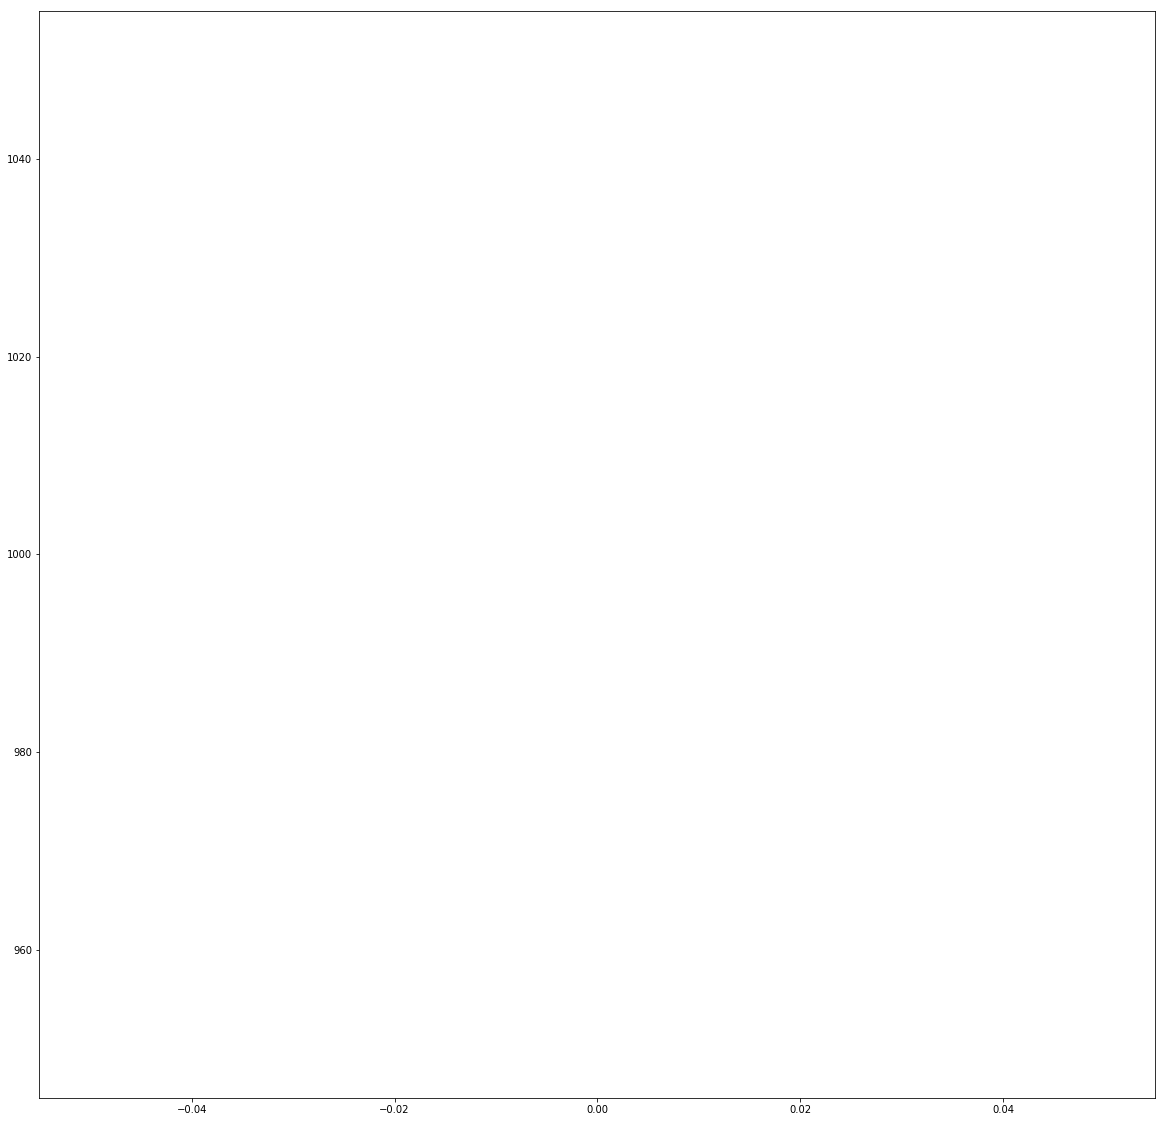

In [280]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(xx, yy)
axs.plot([0, 0], [1000, 1000], 'k-')
plt.show()

In [306]:
model = MinMaxModel()
model.fit(train, train_answers)
tr_stat = model.predict(train).merge(train_answers, on=['itemId'])
tr_stat.head()

,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,6132,39,637,276,831,47,650,213,812
1,31297,25,393,126,487,18,390,122,472
2,18168,159,718,587,1074,35,713,656,1082
3,8398,53,1019,61,1028,51,1021,59,1027
4,8774,116,959,795,1317,205,792,835,1309


In [307]:
scores = tr_stat.apply(lambda x: pd.Series([x.itemId,\
                         intersection_over_union([x.Xmin, x.Ymin, x.Xmax, x.Ymax, x.Xmin_true, x.Ymin_true, x.Xmax_true, x.Ymax_true])]\
                                 , index=['itemId', 'score']), 1)
tr_stat = tr_stat.merge(scores, on=['itemId'])

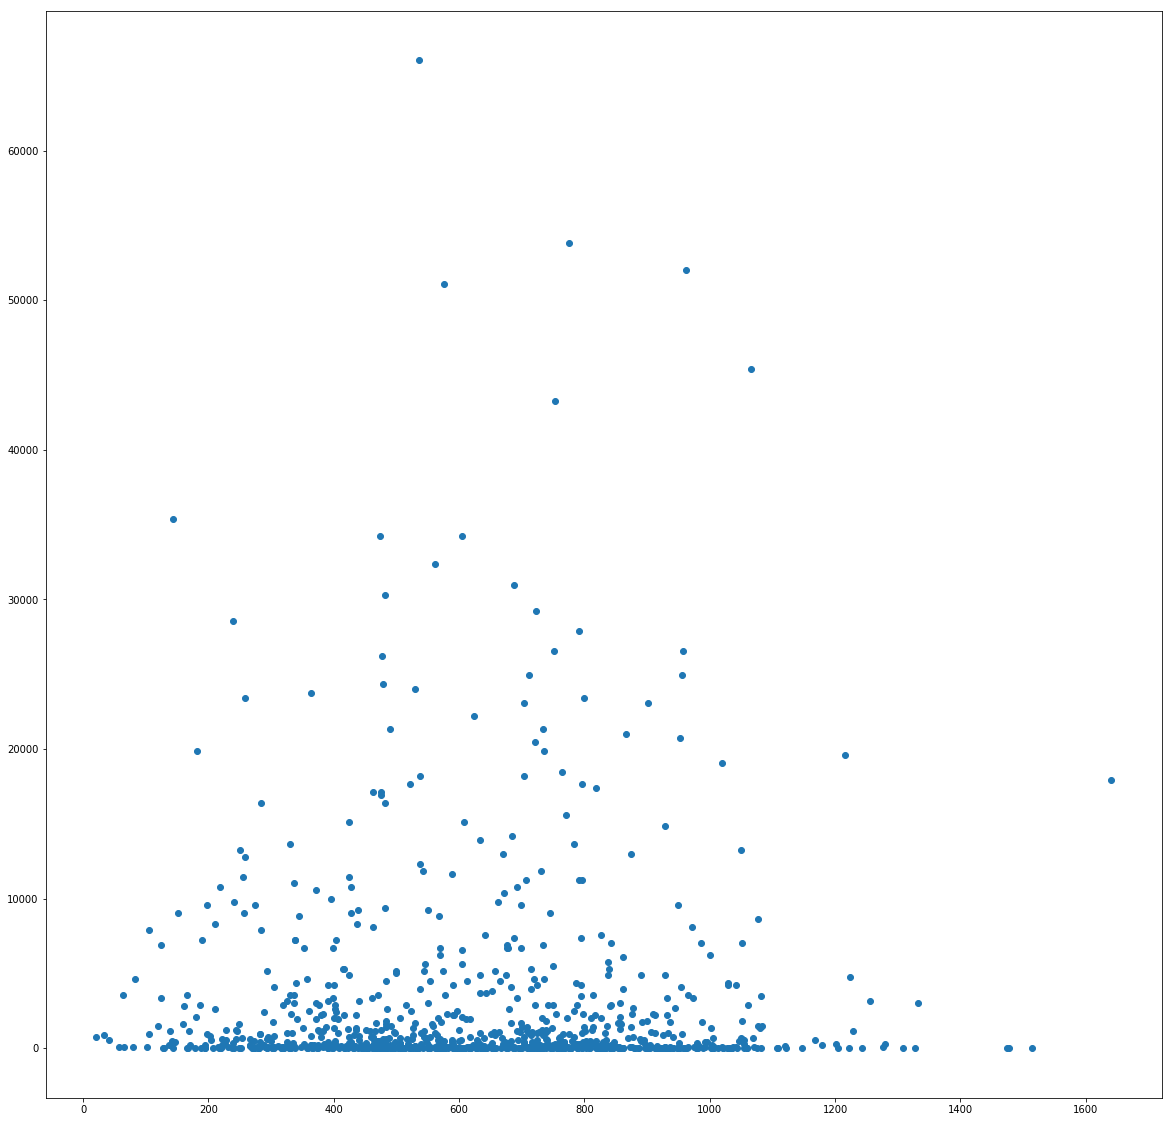

In [314]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(tr_stat.Ymin_true, (tr_stat.Ymin_true - tr_stat.Ymin)**2)
plt.show()

In [161]:
for items in split_by(train, 'itemId'):
    items = list(items.itertuples())
    items = list(map(Rect, items))
    items.sort(key=lambda a: a.x1)
    a = all(items[i - 1].contains(items[i]) for i in range(1, len(items)))
    if (a):
        print(items[0].itemId)


118
2014
5797
8374
8520
11910
13855
16332
16809
16944
17177
18713
18756
23728
25135
26967
27956
29282
31033
31749
32631
35123


In [144]:
a = list(split_by(train, 'itemId')[0].itertuples())[0]

In [147]:
str(type(a))

"<class 'pandas.core.frame.Pandas'>"

In [146]:
pd.core.frame.Pandas

AttributeError: module 'pandas.core.frame' has no attribute 'Pandas'

In [110]:
ee = []
train.groupby('itemId').apply(lambda x: ee.append(x))
ee[0]

,userId,itemId,Xmin,Ymin,Xmax,Ymax
2988,141,5,210,925,483,1255
2989,903,5,151,917,511,1160
2990,1723,5,192,914,510,1331


In [105]:
type(train)

pandas.core.frame.DataFrame

In [112]:
x1_brd = []
x2_brd = []
y1_brd = []
y2_brd = []
for items in split_by(train.join(train_answers.set_index('itemId'), on='itemId'), 'itemId'):
    itemId = items.itemId.values[0]
    rect = Rect([items.Xmin_true.values[0], items.Ymin_true.values[0], items.Xmax_true.values[0], items.Ymax_true.values[0]])
    rect.itemId = items.itemId.values[0]
    rect.userId = items.userId.values[0]
    if items.Xmin.min() == items.Xmin_true.min():
        x1_brd.append(rect)
    if items.Ymin.min() == items.Ymin_true.min():
        y1_brd.append(rect)
    if items.Xmax.max() == items.Xmax_true.max():
        x2_brd.append(rect)
    if items.Ymax.max() == items.Ymax_true.max():
        y2_brd.append(rect)
        
print(len(x1_brd), len(x2_brd), len(y1_brd), len(y2_brd))

30 24 40 31


In [131]:
','.join(map(str, list(map(lambda x: x.itemId, x1_brd)) + list(map(lambda x: x.itemId, x2_brd)) + list(map(lambda x: x.itemId, y1_brd)) + list(map(lambda x: x.itemId, y2_brd))))

'1691,4322,5312,6013,7010,9523,9813,10004,10477,10544,12016,12488,13855,15374,18374,21223,21424,22483,25135,29550,30089,30683,31033,31749,32714,32928,33357,33551,34508,34791,4117,7555,10255,10477,10867,11258,12543,13983,14575,17216,18546,18729,20558,22483,23181,25135,26374,31033,32182,32551,34362,34990,34998,35648,1095,1147,3009,4257,4752,7761,9523,13007,13855,16045,16538,17177,17190,17449,17653,18093,21231,22330,22475,22483,23031,24763,25094,25135,25142,25324,26628,26973,28987,30615,30683,31033,31086,31515,32631,32954,33665,34114,34957,35476,843,1147,3973,4408,5014,9407,10255,11212,11258,12701,13194,13386,13855,14575,15096,22391,22483,23342,23416,23609,25014,25135,25142,25324,26489,28030,28597,29498,30215,31033,34114'

In [114]:
list(map(str, x1_brd))

['Rect[14, 353]*[302, 568]',
 'Rect[23, 58]*[359, 390]',
 'Rect[48, 87]*[819, 853]',
 'Rect[48, 67]*[924, 938]',
 'Rect[15, 244]*[439, 696]',
 'Rect[48, 80]*[854, 880]',
 'Rect[59, 259]*[980, 1134]',
 'Rect[34, 240]*[636, 783]',
 'Rect[40, 121]*[719, 774]',
 'Rect[27, 111]*[552, 594]',
 'Rect[34, 50]*[709, 719]',
 'Rect[21, 631]*[321, 772]',
 'Rect[56, 62]*[1121, 1127]',
 'Rect[41, 157]*[749, 883]',
 'Rect[35, 397]*[596, 783]',
 'Rect[32, 314]*[597, 784]',
 'Rect[40, 61]*[576, 584]',
 'Rect[37, 40]*[768, 770]',
 'Rect[45, 45]*[1243, 1243]',
 'Rect[16, 534]*[342, 663]',
 'Rect[28, 310]*[428, 519]',
 'Rect[45, 123]*[1222, 1300]',
 'Rect[47, 48]*[963, 963]',
 'Rect[56, 63]*[1013, 1019]',
 'Rect[40, 151]*[753, 830]',
 'Rect[31, 46]*[846, 861]',
 'Rect[48, 263]*[897, 1058]',
 'Rect[46, 183]*[960, 1062]',
 'Rect[30, 310]*[857, 1205]',
 'Rect[49, 280]*[890, 1012]']

In [122]:
(train_answers.Xmin_true <= 59).mean()

0.5418875927889714

In [123]:
(train.Xmin <= 59).mean()

0.3509462244706764

In [105]:
str(sorted(list(map(lambda a: a[1], x1_brd))))

'[14, 15, 16, 21, 23, 27, 28, 30, 31, 32, 34, 34, 35, 37, 40, 40, 40, 41, 45, 45, 46, 47, 48, 48, 48, 48, 49, 56, 56, 59]'

In [106]:
str(sorted(list(map(lambda a: a[1], x2_brd))))

'[36, 38, 39, 43, 45, 46, 47, 54, 55, 55, 56, 61, 75, 75, 93, 95, 95, 97, 181, 206, 209, 214, 239, 299]'

In [107]:
str(sorted(list(map(lambda a: a[1], y1_brd))))

'[16, 22, 22, 23, 25, 29, 31, 32, 33, 33, 33, 35, 37, 37, 38, 40, 40, 41, 43, 43, 45, 45, 46, 47, 48, 48, 51, 52, 53, 53, 54, 55, 56, 57, 58, 60, 82, 85, 101, 103]'

In [108]:
str(sorted(list(map(lambda a: a[1], y2_brd))))

'[31, 38, 44, 45, 48, 48, 57, 58, 60, 62, 74, 79, 83, 94, 95, 98, 100, 100, 102, 105, 133, 148, 176, 177, 179, 222, 243, 260, 323, 354, 528]'

In [98]:
train_answers.shape

(943, 5)

In [110]:
sorted(train_answers.Xmin_true.unique())

[-1,
 0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 162,
 163,
 164,
 165,
 167,
 169,
 172,
 173,
 174,
 175,
 176,
 178,
 181,
 186,
 187,
 189,
 193,
 195,
 197,
 198,
 199,
 201,
 202,
 204,
 205,
 207,
 209,
 210,
 211,
 212,
 214,
 215,
 216,
 218

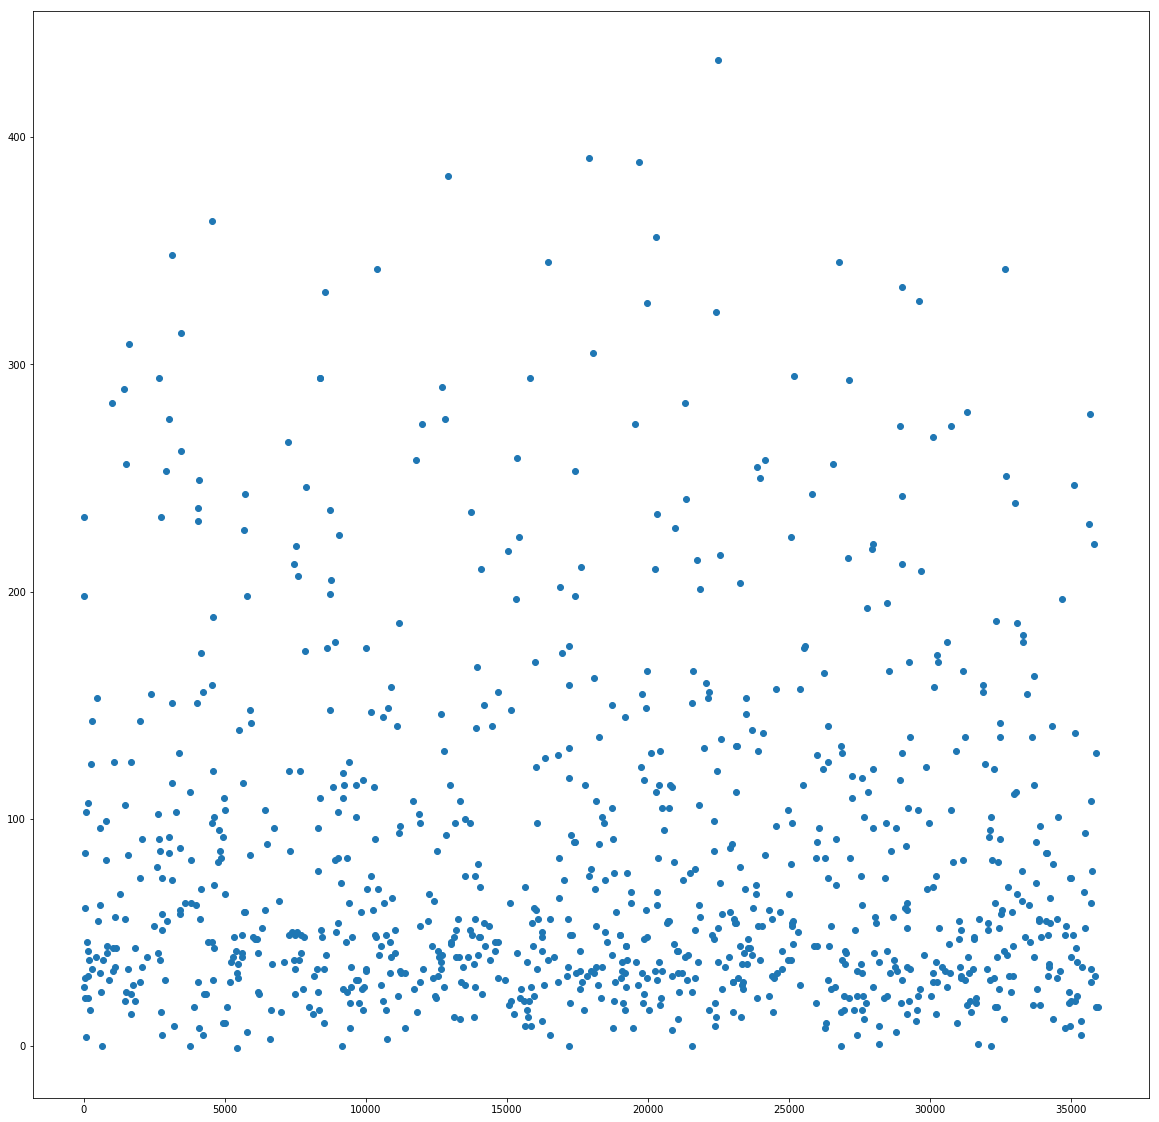

In [120]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.scatter(train_answers.itemId, train_answers.Xmin_true)
plt.show()